In [1]:
from utils import set_env
set_env()
import torch
from peft import LoraConfig, get_peft_model
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig
import copy

/work/cvp352/loi_work/2025/Pro-Cap/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "HuggingFaceM4/idefics-9b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"]
)

In [ ]:
import torchvision.transforms as transforms
processor = AutoProcessor.from_pretrained(checkpoint)
model1 = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=bnb_config, device_map="auto")
print(sum([x.numel() for x in model1.parameters()])/1e9)



Instantiating IdeficsAttention without passing a `layer_idx` is not recommended and will lead to errors during the forward call if caching is used. Please make sure to provide a `layer_idx` when creating this class.
Loading checkpoint shards: 100%|██████████| 19/19 [01:27<00:00,  4.63s/it]


4.5969636


In [29]:
model=copy.deepcopy(model1)

In [28]:
##preprocessing
def convert_to_rgb(image):
  if image.mode == "RGB":
    return image

  image_rgba = image.convert("RGBA")
  background = Image.new("RGBA", image_rgba.size, (255,255,255))
  alpha_composite = Image.alpha_composite(background, image_rgba)
  alpha_composite = alpha_composite.convert("RGB")
  return alpha_composite

def ds_transforms(example_batch):
  image_size = processor.image_processor.image_size
  image_mean = processor.image_processor.image_mean
  image_std = processor.image_processor.image_std

  image_transform = transforms.Compose([
      convert_to_rgb,
      transforms.RandomResizedCrop((image_size, image_size), scale=(0.9, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize(mean=image_mean, std=image_std)
  ])

  prompts = []
  for i in range(len(example_batch['caption'])):
    caption = example_batch['caption'][i].split(".")[0]
    prompts.append(
        [
            example_batch['image_url'][i],
            f"Question: What's on the picture? Answer: {example_batch['name'][0]}</s>",
        ],
    )
  inputs = processor(prompts, transform=image_transform, return_tensors="pt").to(device)
  inputs["labels"] = inputs["input_ids"]
  return inputs

In [30]:
ds1 = torch.load('pokemon_final_dataset.pkl')
ds = copy.deepcopy(ds1.train_test_split(test_size=0.002))
train_ds = ds["train"]
eval_ds = ds["test"]
train_ds.set_transform(ds_transforms)
eval_ds.set_transform(ds_transforms)
train_ds[0]['labels']

/tmp/ipykernel_1848721/4127688259.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ds1 = torch.load('pokemon_final_dataset.pkl')


tensor([    1, 32000, 32001, 32000,   894, 29901,  1724, 29915, 29879,   373,
          278,  7623, 29973,   673, 29901,  4168,   265, 29915, 29879, 10513,
          307,   311,     2], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


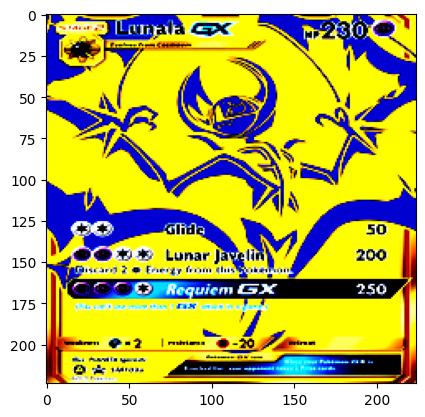

In [9]:
import matplotlib.pyplot as plt
plt.imshow( train_ds[0]['pixel_values'].cpu().squeeze(0).permute(1,2,0))

In [32]:
model_name = checkpoint.split("/")[1]
config = LoraConfig(
    r = 16,
    lora_alpha = 32,
    target_modules = ["q_proj", "k_proj", "v_proj"],
    lora_dropout = 0.05,
    bias="none"
)
model = get_peft_model(model, config)
model.print_trainable_parameters()
training_args = TrainingArguments(
    output_dir = f"{model_name}-PokemonCards",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    eval_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 10,
    save_steps = 25,
    max_steps = 25,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = eval_ds
)
trainer.train()

trainable params: 19,750,912 || all params: 8,949,430,544 || trainable%: 0.2207


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
10,12.154700,0.532579
20,3.571800,0.362452


TrainOutput(global_step=25, training_loss=9.155729217529297, metrics={'train_runtime': 96.4795, 'train_samples_per_second': 4.146, 'train_steps_per_second': 0.259, 'total_flos': 415646256333312.0, 'train_loss': 9.155729217529297, 'epoch': 0.030623181748583677})

In [38]:
# Inference
def do_inference(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    inputs = processor(prompts, return_tensors="pt").to(device)
    generated_ids = model.generate(
        **inputs,
        eos_token_id=[tokenizer.convert_tokens_to_ids("</s>")],
        bad_words_ids=tokenizer(["<image>", "<fake_token_around_image>"], add_special_tokens=False).input_ids,
        max_new_tokens=max_new_tokens,
        stop_strings=["\n",'.'],
        tokenizer=tokenizer
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)
for i in range(10):
    do_inference(model, processor, [
        ds1['image_url'][i],
        "Question: What's on the picture? Answer:",
    ], max_new_tokens=100)
    print('key',ds1[i]['name'])

Question: What's on the picture? Answer: Absol
key Absol G
Question: What's on the picture? Answer: Aerodactyl
key Aerodactyl
Question: What's on the picture? Answer: Weedle
key Weedle
Question: What's on the picture? Answer: Caterpie
key Caterpie
Question: What's on the picture? Answer: Azumarill
key Azumarill
Question: What's on the picture? Answer: Bulbasaur
key Bulbasaur
Question: What's on the picture? Answer: Venusaur
key Venusaur
Question: What's on the picture? Answer: Absol
key Absol
Question: What's on the picture? Answer: Aegislash
key Aggron
Question: What's on the picture? Answer: Beedrill
key Beedrill δ


In [34]:
processor.tokenizer.decode(train_ds[0]['labels'])

"<s><fake_token_around_image><image><fake_token_around_image> Question: What's on the picture? Answer: Holon's Electrode</s>"

In [35]:
do_inference(model1, processor, prompts, max_new_tokens=100)

Question: What's on the picture? Answer: Absol's Pokémon Card.


In [19]:
import pandas as pd
kk=pd.Series([x['name'] for x in ds1]).value_counts()
kk.head(n=20)

Pikachu       88
Eevee         54
Raichu        38
Unown         36
Magnemite     36
Charmander    33
Magneton      33
Snorlax       32
Meowth        30
Voltorb       30
Magikarp      30
Electrode     29
Vulpix        28
Ninetales     27
Torchic       27
Lapras        27
Charizard     27
Growlithe     26
Lucario       26
Gyarados      26
Name: count, dtype: int64